# Nuclear Morphology and Chromatin Feature Extraction

This notebook processes microscopy images to:
1. Filter out noise particles that aren't nuclei
2. Extract comprehensive nuclear features from all valid nuclei
3. Save the features to a CSV file for further analysis

In [2]:
# Import libraries
%load_ext autoreload
import sys
sys.path.append("../")

from tifffile import imread, imsave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from datetime import datetime
from skimage import measure, morphology, segmentation

from nmco.nuclear_features import (
    global_morphology as BG,
    img_texture as IT,
    int_dist_features as IDF,
    boundary_local_curvature as BLC
)

from tqdm.notebook import tqdm  # For progress bars

## Load Input Images

Provide the paths to your raw intensity image and segmentation mask.

In [3]:
# Define image paths - modify these as needed
labelled_image_path = os.path.join(os.path.dirname(os.getcwd()), 'example_data/009_G11_segmented.tif')
raw_image_path = os.path.join(os.path.dirname(os.getcwd()), 'example_data/009_G11_raw.tif')

# Output folder for saving results
output_folder = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(output_folder, exist_ok=True)

# Load the images
labelled_image = imread(labelled_image_path).astype(int)
raw_image = imread(raw_image_path).astype(int)

# Normalize raw image intensity
raw_image = cv.normalize(raw_image, None, alpha=0, beta=150, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

## Preprocess the Segmentation Mask

Convert binary mask to proper labeled image and visualize it.

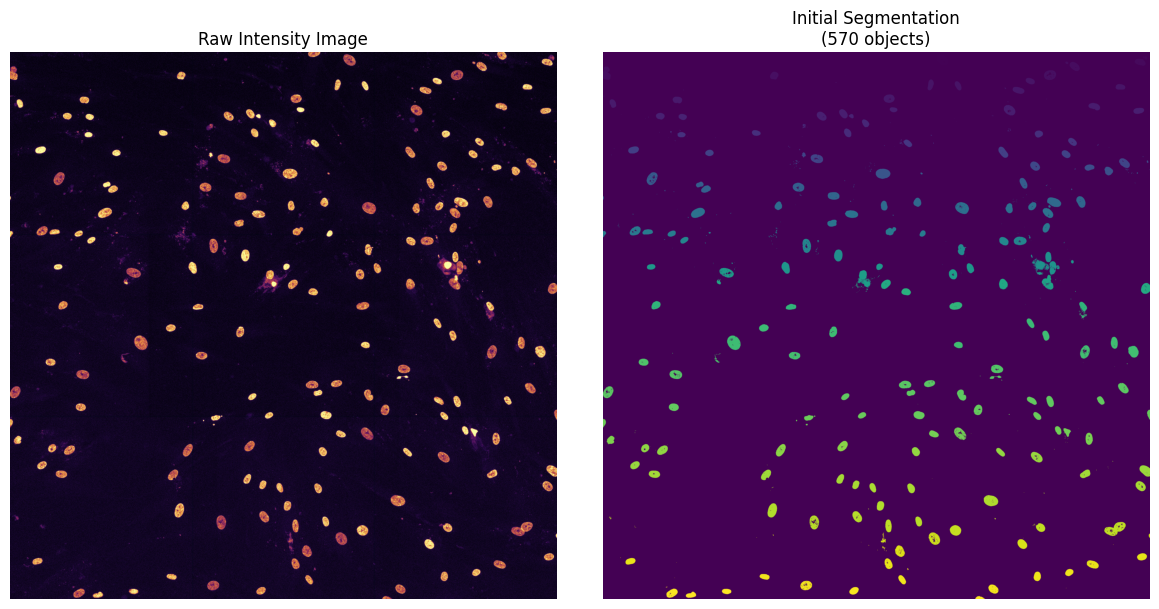

In [4]:
# Convert binary mask (0,255) → Labeled Image (1,2,3,...)
binary_mask = labelled_image > 0
labelled_image = measure.label(binary_mask, connectivity=2)

# Display the raw and labeled images
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.imshow(raw_image, cmap='inferno')
ax0.set_title("Raw Intensity Image")
ax0.axis('off')

ax1.imshow(labelled_image, cmap='viridis')
ax1.set_title(f"Initial Segmentation\n({labelled_image.max()} objects)")
ax1.axis('off')

plt.tight_layout()
plt.show()

## Filter Out Non-Nuclear Objects

Remove small particles and other noise that aren't true nuclei.

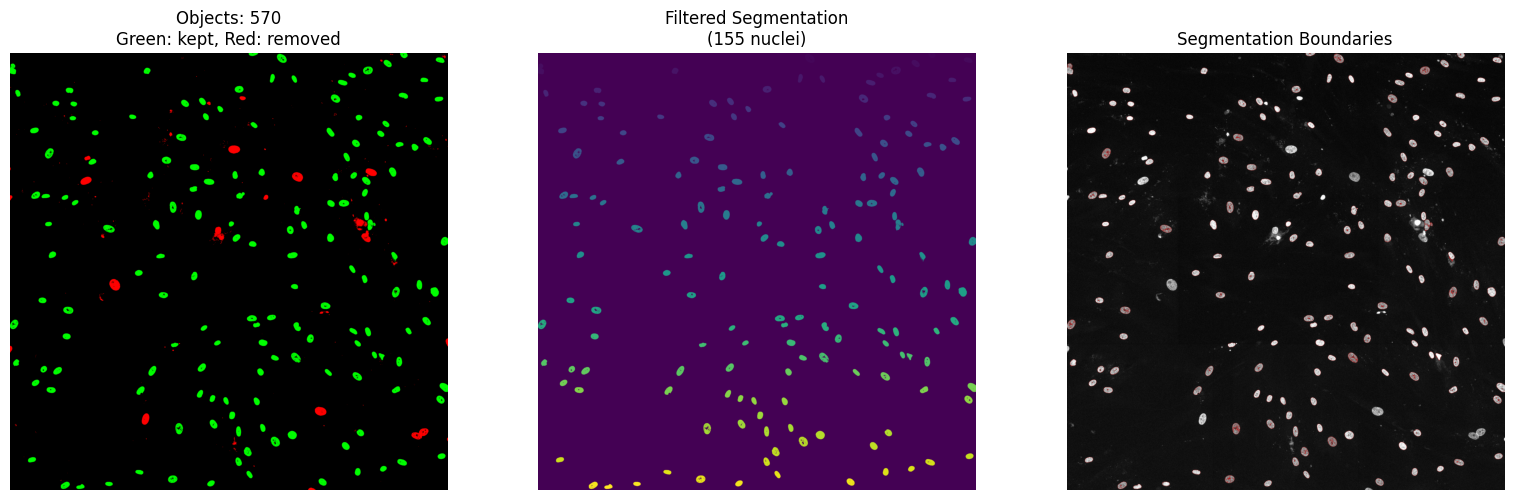

Before filtering: 570 objects
After filtering: 155 nuclei
Removed: 415 objects


In [5]:
# Set thresholds for filtering
MIN_NUCLEUS_AREA = 4000  # Minimum area in pixels to be considered a nucleus
MAX_NUCLEUS_AREA = 12000  # Maximum area to exclude giant clumps/artifacts
MAX_ECCENTRICITY = 2.9   # Maximum eccentricity to exclude extremely elongated objects

# Get region properties
props_all = measure.regionprops(labelled_image, intensity_image=raw_image)

# Create a mask for valid nuclei
valid_nuclei_mask = np.zeros_like(labelled_image, dtype=bool)
valid_labels = []
invalid_labels = []

for prop in props_all:
    if MIN_NUCLEUS_AREA <= prop.area <= MAX_NUCLEUS_AREA and prop.eccentricity < MAX_ECCENTRICITY:
        # Additional filtering based on solidity if needed
        #if prop.solidity > 0.8:  # Objects should be reasonably solid/filled
        valid_nuclei_mask[tuple(prop.coords.T)] = True
        valid_labels.append(prop.label)
    else:
        invalid_labels.append(prop.label)

# Relabel the filtered mask
filtered_labelled_image = measure.label(valid_nuclei_mask)

# Visualize the filtering results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original labeled image with color-coded filtering
overlay = np.zeros((*labelled_image.shape, 3))
for prop in props_all:
    if prop.label in valid_labels:
        # Valid nuclei in green
        overlay[labelled_image == prop.label] = [0, 1, 0]  
    else:
        # Invalid objects in red
        overlay[labelled_image == prop.label] = [1, 0, 0]  

axes[0].imshow(overlay)
axes[0].set_title(f'Objects: {len(props_all)}\nGreen: kept, Red: removed')
axes[0].axis('off')

# Filtered labeled image
axes[1].imshow(filtered_labelled_image, cmap='viridis')
axes[1].set_title(f'Filtered Segmentation\n({len(valid_labels)} nuclei)')
axes[1].axis('off')

# Show boundaries on raw image
boundaries = segmentation.find_boundaries(filtered_labelled_image)
rgb_raw = np.dstack([raw_image/raw_image.max()]*3)  # Convert to RGB
rgb_raw[boundaries] = [1, 0, 0]  # Red boundaries

axes[2].imshow(rgb_raw)
axes[2].set_title('Segmentation Boundaries')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Before filtering: {len(props_all)} objects")
print(f"After filtering: {len(valid_labels)} nuclei")
print(f"Removed: {len(invalid_labels)} objects")

# Update our labeled image with the filtered version
labelled_image = filtered_labelled_image.copy()

## Size Distribution Analysis

Visualize the size distribution of the filtered nuclei.

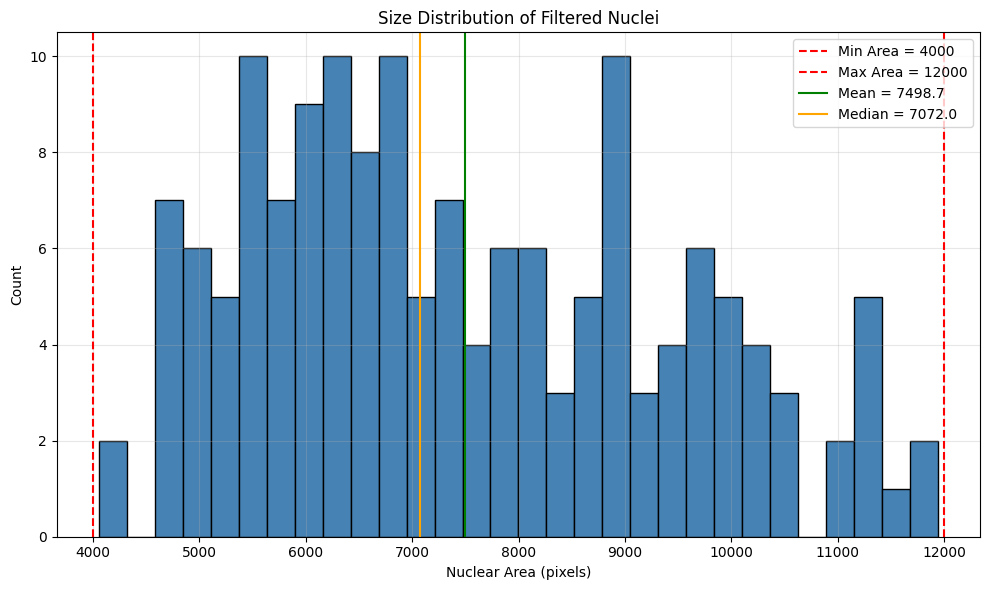

In [6]:
# Get region properties for the filtered image
props = measure.regionprops(labelled_image, intensity_image=raw_image)

# Extract nuclei areas
areas = [prop.area for prop in props]

# Plot size distribution
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=30, color='steelblue', edgecolor='black')
plt.title('Size Distribution of Filtered Nuclei')
plt.xlabel('Nuclear Area (pixels)')
plt.ylabel('Count')
plt.axvline(MIN_NUCLEUS_AREA, color='red', linestyle='--', label=f'Min Area = {MIN_NUCLEUS_AREA}')
plt.axvline(MAX_NUCLEUS_AREA, color='red', linestyle='--', label=f'Max Area = {MAX_NUCLEUS_AREA}')
plt.axvline(np.mean(areas), color='green', linestyle='-', label=f'Mean = {np.mean(areas):.1f}')
plt.axvline(np.median(areas), color='orange', linestyle='-', label=f'Median = {np.median(areas):.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Extraction Function

Define a function to extract all features from a single nucleus.

In [10]:
def extract_nucleus_features(nucleus_properties):
    """
    Extract all features for a single nucleus
    
    Args:
        nucleus_properties: Properties of a single nucleus from regionprops
        
    Returns:
        DataFrame row with all the features for this nucleus
    """
    # Get binary mask and intensity image
    binary_mask = nucleus_properties.image
    intensity_img = nucleus_properties.intensity_image
    
    # Initialize features dictionary with the nucleus label
    features_dict = {'label': nucleus_properties.label}
    
    try:
        # 1. Basic regionprops features
        regionprops_features = {
            'area': nucleus_properties.area,
            'perimeter': nucleus_properties.perimeter,
            'eccentricity': nucleus_properties.eccentricity,
            'solidity': nucleus_properties.solidity,
            'equivalent_diameter': nucleus_properties.equivalent_diameter,
            'major_axis_length': nucleus_properties.major_axis_length,
            'minor_axis_length': nucleus_properties.minor_axis_length,
            'orientation': nucleus_properties.orientation,
        }
        features_dict.update(regionprops_features)
        
        # 2. Global morphology features
        morphology_features = BG.measure_global_morphometrics(binary_mask)
        features_dict.update(morphology_features.to_dict())
        
        # 3. Local boundary curvature features (use smaller step for small nuclei)
        step_size = 5 if nucleus_properties.area > 500 else 3
        curvature_features = BLC.measure_curvature_features(binary_mask, step=step_size)
        features_dict.update(curvature_features.to_dict())
        
        # 4. Intensity distribution features
        intensity_features = IDF.measure_intensity_features(binary_mask, intensity_img)
        features_dict.update(intensity_features.to_dict())
        
        # 5. Texture features
        texture_features = IT.measure_texture_features(binary_mask, intensity_img)
        features_dict.update(texture_features.to_dict())
        
        # Create dataframe from the dictionary
        return pd.DataFrame([features_dict])
        
    except Exception as e:
        print(f"Error processing nucleus {nucleus_properties.label}: {str(e)}")
        return None

## Process All Nuclei

Extract features from all valid nuclei in the image.

In [16]:
# Get region properties for the filtered image
from tqdm import tqdm 
props = measure.regionprops(labelled_image, intensity_image=raw_image)

# Initialize empty dataframe for all nuclei features
all_nuclei_features = pd.DataFrame()

# Process each nucleus with a progress bar
print(f"Extracting features from {len(props)} nuclei...")

for i, prop in enumerate(tqdm(props)):
    # Extract features for this nucleus
    nucleus_features = extract_nucleus_features(prop)
    
    # If successful, add to the master dataframe
    if nucleus_features is not None:
        all_nuclei_features = pd.concat([all_nuclei_features, nucleus_features], ignore_index=True)
    
    # Optional: Display progress update every 20 nuclei
    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{len(props)} nuclei")

print(f"Successfully extracted features from {len(all_nuclei_features)} nuclei")

Extracting features from 155 nuclei...








Exception ignored in: <function tqdm.__del__ at 0x15dd6a3e0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x15dd6a3e0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exceptio

Processed 20/155 nuclei


Processed 40/155 nuclei


Processed 60/155 nuclei


Processed 80/155 nuclei


Processed 100/155 nuclei


Processed 120/155 nuclei


Processed 140/155 nuclei























100%|██████████| 155/155 [00:12<00:00, 12.09it/s]

Successfully extracted features from 155 nuclei


## Save Results to CSV

Save the extracted features to a CSV file.

In [18]:
# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_filename = os.path.basename(raw_image_path).split('.')[0]
csv_filename = f"{base_filename}_features_{timestamp}.csv"
csv_path = os.path.join(output_folder, csv_filename)

# Save to CSV
all_nuclei_features.to_csv(csv_path, index=False)
print(f"Features saved to: {csv_path}")

# Display summary of the features
print(f"\nFeature set contains {len(all_nuclei_features)} nuclei with {len(all_nuclei_features.columns)} features per nucleus")
print(f"\nFeature categories:")
print(f"Basic regionprops features: area, perimeter, eccentricity, etc.")
print(f"Global morphology features: caliper_length, sphericity, etc.")
print(f"Boundary curvature features: curvature_mean, curvature_std, etc.")
print(f"Intensity features: median_intensity, hetero_ratio, etc.")
print(f"Texture features: glcm_contrast, glcm_correlation, etc.")

Features saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/009_G11_raw_features_20250318_104752.csv

Feature set contains 155 nuclei with 202 features per nucleus

Feature categories:
Basic regionprops features: area, perimeter, eccentricity, etc.
Global morphology features: caliper_length, sphericity, etc.
Boundary curvature features: curvature_mean, curvature_std, etc.
Intensity features: median_intensity, hetero_ratio, etc.
Texture features: glcm_contrast, glcm_correlation, etc.


Pipelined Nuclear Feature Extraction and saving each image as a CSV.


In [19]:
# -*- coding: utf-8 -*-
"""Full_Nuclear_Feature_Extraction_Pipeline.py

This script processes all microscopy image pairs in a directory to:
1. Filter out noise particles that aren't nuclei
2. Extract comprehensive nuclear features from all valid nuclei
3. Save the features to CSV files for further analysis
"""

# Import libraries
import sys
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tifffile import imread
from skimage import measure, segmentation
from tqdm import tqdm

# Import feature extraction modules
from nmco.nuclear_features import (
    global_morphology as BG,
    img_texture as IT,
    int_dist_features as IDF,
    boundary_local_curvature as BLC
)

# Configuration parameters
MIN_NUCLEUS_AREA = 4000  # Minimum area in pixels to be considered a nucleus
MAX_NUCLEUS_AREA = 12000  # Maximum area to exclude giant clumps/artifacts
MAX_ECCENTRICITY = 2.9   # Maximum eccentricity to exclude extremely elongated objects

def extract_nucleus_features(nucleus_properties):
    """
    Extract all features for a single nucleus

    Args:
        nucleus_properties: Properties of a single nucleus from regionprops

    Returns:
        DataFrame row with all the features for this nucleus
    """
    # Get binary mask and intensity image
    binary_mask = nucleus_properties.image
    intensity_img = nucleus_properties.intensity_image

    # Initialize features dictionary with the nucleus label
    features_dict = {'label': nucleus_properties.label}

    try:
        # 1. Basic regionprops features
        regionprops_features = {
            'area': nucleus_properties.area,
            'perimeter': nucleus_properties.perimeter,
            'eccentricity': nucleus_properties.eccentricity,
            'solidity': nucleus_properties.solidity,
            'equivalent_diameter': nucleus_properties.equivalent_diameter,
            'major_axis_length': nucleus_properties.major_axis_length,
            'minor_axis_length': nucleus_properties.minor_axis_length,
            'orientation': nucleus_properties.orientation,
        }
        features_dict.update(regionprops_features)

        # 2. Global morphology features
        morphology_features = BG.measure_global_morphometrics(binary_mask)
        features_dict.update(morphology_features.to_dict())

        # 3. Local boundary curvature features (use smaller step for small nuclei)
        step_size = 5 if nucleus_properties.area > 500 else 3
        curvature_features = BLC.measure_curvature_features(binary_mask, step=step_size)
        features_dict.update(curvature_features.to_dict())

        # 4. Intensity distribution features
        intensity_features = IDF.measure_intensity_features(binary_mask, intensity_img)
        features_dict.update(intensity_features.to_dict())

        # 5. Texture features
        texture_features = IT.measure_texture_features(binary_mask, intensity_img)
        features_dict.update(texture_features.to_dict())

        # Create dataframe from the dictionary
        return pd.DataFrame([features_dict])

    except Exception as e:
        print(f"Error processing nucleus {nucleus_properties.label}: {str(e)}")
        return None

def process_image_pair(raw_image_path, labelled_image_path, output_folder):
    """
    Process a single pair of raw and segmented images
    
    Args:
        raw_image_path: Path to the raw intensity image
        labelled_image_path: Path to the segmentation mask
        output_folder: Folder to save results
        
    Returns:
        Path to the saved CSV file
    """
    print(f"\nProcessing image pair: {os.path.basename(raw_image_path)} & {os.path.basename(labelled_image_path)}")
    
    # Load the images
    labelled_image = imread(labelled_image_path).astype(int)
    raw_image = imread(raw_image_path).astype(int)

    # Normalize raw image intensity
    raw_image = cv.normalize(raw_image, None, alpha=0, beta=150, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

    # Convert binary mask (0,255) → Labeled Image (1,2,3,...)
    binary_mask = labelled_image > 0
    labelled_image = measure.label(binary_mask, connectivity=2)
    
    print(f"Initial segmentation contains {labelled_image.max()} objects")
    
    # Filter out non-nuclear objects
    props_all = measure.regionprops(labelled_image, intensity_image=raw_image)
    
    # Create a mask for valid nuclei
    valid_nuclei_mask = np.zeros_like(labelled_image, dtype=bool)
    valid_labels = []
    invalid_labels = []

    for prop in props_all:
        if MIN_NUCLEUS_AREA <= prop.area <= MAX_NUCLEUS_AREA and prop.eccentricity < MAX_ECCENTRICITY:
            valid_nuclei_mask[tuple(prop.coords.T)] = True
            valid_labels.append(prop.label)
        else:
            invalid_labels.append(prop.label)

    # Relabel the filtered mask
    filtered_labelled_image = measure.label(valid_nuclei_mask)
    
    print(f"Before filtering: {len(props_all)} objects")
    print(f"After filtering: {len(valid_labels)} nuclei")
    print(f"Removed: {len(invalid_labels)} objects")
    
    # Update our labeled image with the filtered version
    labelled_image = filtered_labelled_image.copy()
    
    # Get region properties for the filtered image
    props = measure.regionprops(labelled_image, intensity_image=raw_image)
    
    # Initialize empty dataframe for all nuclei features
    all_nuclei_features = pd.DataFrame()
    
    # Process each nucleus with a progress bar
    print(f"Extracting features from {len(props)} nuclei...")
    
    for i, prop in enumerate(tqdm(props)):
        # Extract features for this nucleus
        nucleus_features = extract_nucleus_features(prop)

        # If successful, add to the master dataframe
        if nucleus_features is not None:
            all_nuclei_features = pd.concat([all_nuclei_features, nucleus_features], ignore_index=True)

    print(f"Successfully extracted features from {len(all_nuclei_features)} nuclei")
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_filename = os.path.basename(raw_image_path).split('.')[0]
    csv_filename = f"{base_filename}_features_{timestamp}.csv"
    csv_path = os.path.join(output_folder, csv_filename)

    # Save to CSV
    all_nuclei_features.to_csv(csv_path, index=False)
    print(f"Features saved to: {csv_path}")
    
    return csv_path

def find_image_pairs(data_folder):
    """
    Find all pairs of raw and segmented images in the data folder
    
    Args:
        data_folder: Folder containing the images
        
    Returns:
        List of tuples (raw_path, segmented_path)
    """
    # Get all TIFF files in the folder
    all_files = [f for f in os.listdir(data_folder) if f.endswith('.tif')]
    
    # Separate raw and segmented files
    raw_files = [f for f in all_files if '_raw.tif' in f]
    segmented_files = [f for f in all_files if '_segmented.tif' in f]
    
    # Create pairs based on matching base names
    pairs = []
    for raw_file in raw_files:
        # Extract the base name (e.g., "009_G11" from "009_G11_raw.tif")
        base_name = raw_file.replace('_raw.tif', '')
        segmented_file = f"{base_name}_segmented.tif"
        
        if segmented_file in segmented_files:
            raw_path = os.path.join(data_folder, raw_file)
            segmented_path = os.path.join(data_folder, segmented_file)
            pairs.append((raw_path, segmented_path))
    
    return pairs

def main():
    """Main function to run the pipeline"""
    # Define input and output folders
    data_folder = os.path.join(os.path.dirname(os.getcwd()), 'example_data')
    output_folder = os.path.join(os.path.dirname(os.getcwd()), 'results')
    os.makedirs(output_folder, exist_ok=True)
    
    # Find all image pairs
    image_pairs = find_image_pairs(data_folder)
    print(f"Found {len(image_pairs)} image pairs to process")
    
    # Process each pair
    results = []
    for i, (raw_path, segmented_path) in enumerate(image_pairs):
        print(f"\n[{i+1}/{len(image_pairs)}] Processing pair: {os.path.basename(raw_path)}")
        try:
            csv_path = process_image_pair(raw_path, segmented_path, output_folder)
            results.append({
                'raw_image': os.path.basename(raw_path),
                'segmented_image': os.path.basename(segmented_path),
                'status': 'Success',
                'output': os.path.basename(csv_path)
            })
        except Exception as e:
            print(f"Error processing {os.path.basename(raw_path)}: {str(e)}")
            results.append({
                'raw_image': os.path.basename(raw_path),
                'segmented_image': os.path.basename(segmented_path),
                'status': 'Failed',
                'error': str(e)
            })
    
    # Save summary report
    report_df = pd.DataFrame(results)
    report_path = os.path.join(output_folder, f"processing_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    report_df.to_csv(report_path, index=False)
    
    print(f"\nPipeline completed. Processed {len(results)} image pairs.")
    print(f"Summary report saved to: {report_path}")
    
    # Display summary
    successful = sum(1 for r in results if r['status'] == 'Success')
    failed = sum(1 for r in results if r['status'] == 'Failed')
    print(f"\nSuccessful: {successful}, Failed: {failed}")

if __name__ == "__main__":
    main()

Found 7 image pairs to process

[1/7] Processing pair: 012_G14_raw.tif

Processing image pair: 012_G14_raw.tif & 012_G14_segmented.tif
Initial segmentation contains 406 objects
Before filtering: 406 objects
After filtering: 123 nuclei
Removed: 283 objects
Extracting features from 123 nuclei...


100%|██████████| 123/123 [00:09<00:00, 13.13it/s]


Successfully extracted features from 123 nuclei
Features saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/012_G14_raw_features_20250318_105157.csv

[2/7] Processing pair: 009_G11_raw.tif

Processing image pair: 009_G11_raw.tif & 009_G11_segmented.tif
Initial segmentation contains 570 objects
Before filtering: 570 objects
After filtering: 155 nuclei
Removed: 415 objects
Extracting features from 155 nuclei...


Exception ignored in: <function tqdm.__del__ at 0x15dd6a3e0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
100%|██████████| 155/155 [00:11<00:00, 13.17it/s]


Successfully extracted features from 155 nuclei
Features saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/009_G11_raw_features_20250318_105209.csv

[3/7] Processing pair: 014_G16_raw.tif

Processing image pair: 014_G16_raw.tif & 014_G16_segmented.tif
Initial segmentation contains 583 objects
Before filtering: 583 objects
After filtering: 123 nuclei
Removed: 460 objects
Extracting features from 123 nuclei...


100%|██████████| 123/123 [00:09<00:00, 12.60it/s]


Successfully extracted features from 123 nuclei
Features saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/014_G16_raw_features_20250318_105220.csv

[4/7] Processing pair: 011_G13_raw.tif

Processing image pair: 011_G13_raw.tif & 011_G13_segmented.tif
Initial segmentation contains 520 objects
Before filtering: 520 objects
After filtering: 122 nuclei
Removed: 398 objects
Extracting features from 122 nuclei...


100%|██████████| 122/122 [00:08<00:00, 13.89it/s]


Successfully extracted features from 122 nuclei
Features saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/011_G13_raw_features_20250318_105229.csv

[5/7] Processing pair: 013_G15_raw.tif

Processing image pair: 013_G15_raw.tif & 013_G15_segmented.tif
Initial segmentation contains 658 objects
Before filtering: 658 objects
After filtering: 140 nuclei
Removed: 518 objects
Extracting features from 140 nuclei...


100%|██████████| 140/140 [00:10<00:00, 13.67it/s]


Successfully extracted features from 140 nuclei
Features saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/013_G15_raw_features_20250318_105240.csv

[6/7] Processing pair: 008_G10_raw.tif

Processing image pair: 008_G10_raw.tif & 008_G10_segmented.tif
Initial segmentation contains 440 objects
Before filtering: 440 objects
After filtering: 133 nuclei
Removed: 307 objects
Extracting features from 133 nuclei...


100%|██████████| 133/133 [00:10<00:00, 13.08it/s]


Successfully extracted features from 133 nuclei
Features saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/008_G10_raw_features_20250318_105251.csv

[7/7] Processing pair: 015_G17_raw.tif

Processing image pair: 015_G17_raw.tif & 015_G17_segmented.tif
Initial segmentation contains 924 objects
Before filtering: 924 objects
After filtering: 148 nuclei
Removed: 776 objects
Extracting features from 148 nuclei...


100%|██████████| 148/148 [00:11<00:00, 12.58it/s]

Successfully extracted features from 148 nuclei
Features saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/015_G17_raw_features_20250318_105304.csv

Pipeline completed. Processed 7 image pairs.
Summary report saved to: /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/processing_report_20250318_105304.csv

Successful: 7, Failed: 0


PCA Pipeline and Visualisations

In [35]:
import pandas as pd

df=pd.read_csv('/Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/008_G10_raw_features_20250318_005509.csv')

df.head()


,label,area,perimeter,eccentricity,solidity,equivalent_diameter,major_axis_length,minor_axis_length,orientation,min_calliper,...,moments_central-3-1,moments_central-3-2,moments_central-3-3,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6
0,1,{0: 7132.0},{0: 383.18585822512665},{0: 0.6977162891700213},{0: 0.963133018230925},{0: 95.29294010078176},{0: 112.74069384015243},{0: 80.7645232084258},{0: -1.480529335399547},{0: 82},...,{0: -175612419.55955938},{0: 545573966.7244081},{0: -248814786863.00436},{0: 0.16854820051040498},{0: 0.002940191569756324},{0: 4.5756098416877665e-06},{0: 1.0268679772360855e-07},{0: -4.573883734341876e-14},{0: -4.109360368254735e-09},{0: -5.350120303951933e-14}
1,2,{0: 5524.0},{0: 317.3452377915607},{0: 0.679309096715809},{0: 0.9632083696599826},{0: 83.8652207122657},{0: 97.96504216307422},{0: 71.89186836743774},{0: 0.8398238941581334},{0: 72},...,{0: 656419681.8109931},{0: 540446655.7392907},{0: 499163660036.36804},{0: 0.16706180104288},{0: 0.0025107700246558514},{0: 3.744118838812452e-07},{0: 8.409484851654579e-09},{0: -1.7260057969211708e-16},{0: -1.985640869783704e-10},{0: -4.3917768269468135e-16}
2,3,{0: 11391.0},{0: 1190.9667376038697},{0: 0.8181322870154009},{0: 0.9010441385856668},{0: 120.43036018412566},{0: 166.26542386006946},{0: 95.60761536272985},{0: -1.385863856647915},{0: 92},...,{0: -3203848736.069896},{0: -2617168732.749771},{0: -6890220885022.752},{0: 0.20183152975329346},{0: 0.010307141417374672},{0: 4.893246075692287e-05},{0: 6.271299686785395e-06},{0: 1.058153109463851e-10},{0: 6.361330241182063e-07},{0: -2.953094052795477e-11}
3,4,{0: 5567.0},{0: 326.6883835420683},{0: 0.758158800766597},{0: 0.9628156347284677},{0: 84.19100038329898},{0: 104.49019538352661},{0: 68.13491753099915},{0: 0.37838878377711305},{0: 71},...,{0: 952459926.88564},{0: 1640799306.5621784},{0: 485650254140.8739},{0: 0.17469651426086333},{0: 0.004964328131853142},{0: 3.792189139723742e-05},{0: 1.2961420436560367e-06},{0: -2.438605816934907e-12},{0: -4.492952482005746e-08},{0: 8.753744916519045e-12}
4,5,{0: 8350.0},{0: 627.4833688019348},{0: 0.8391793198848498},{0: 0.9312960071380771},{0: 103.10940887493541},{0: 141.50906244176778},{0: 76.96038618226139},{0: -1.2172410486652216},{0: 77},...,{0: -2285449575.2307367},{0: 1049739710.4518661},{0: -4136663891559.0176},{0: 0.19421942959933336},{0: 0.011141487814178924},{0: 8.865046404249588e-05},{0: 2.435029222060781e-05},{0: 1.1145594280825652e-09},{0: 2.4294537705412397e-06},{0: 1.9418773192772586e-10}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import glob

# Define the results directory path
results_dir = "/Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/"

# Get all CSV files in the results directory
csv_files = glob.glob(os.path.join(results_dir, "*.csv"))

# Create a list to store all processed dataframes
all_dfs = []
file_names = []  # Store filenames to track source image

# Process and merge each CSV file
for file_path in csv_files:
    try:
        # Extract filename for tracking
        filename = os.path.basename(file_path)
        print(f"Processing {filename}...")
        
        # Load data
        df = pd.read_csv(file_path)
        
        # Fix dictionary-like string values in columns
        df_fixed = df.copy()
        for col in df.columns:
            if df[col].dtype == object:  # Only process non-numeric columns
                try:
                    df_fixed[col] = df[col].apply(lambda x: ast.literal_eval(x.replace("nan", "0.0"))[0] 
                                              if isinstance(x, str) and x.startswith("{") else x)
                except:
                    # If there's an error, try to convert directly or set to NaN
                    print(f"Warning: Could not parse column {col} in {filename}. Setting to NaN.")
                    df_fixed[col] = pd.NA
        
        # Convert extracted values to float
        df_fixed = df_fixed.select_dtypes(exclude=['object'])  # Exclude any remaining object columns
        
        # Drop 'label' column if it exists
        if 'label' in df_fixed.columns:
            df_fixed.drop(columns=['label'], inplace=True)
        
        # Check if there are any valid numerical columns
        if df_fixed.shape[1] == 0:
            print(f"Warning: No valid numerical columns in {filename}. Skipping.")
            continue
        
        # Handle missing values
        df_fixed = df_fixed.fillna(df_fixed.mean())
        
        # Add source file information
        df_fixed['source_file'] = filename
        
        # Store processed dataframe
        all_dfs.append(df_fixed)
        file_names.append(filename)
        
        print(f"Added {filename} with {df_fixed.shape[0]} samples and {df_fixed.shape[1]-1} features")
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

# Merge all dataframes
if len(all_dfs) > 0:
    # Find common columns across all dataframes
    common_cols = set(all_dfs[0].columns)
    for df in all_dfs[1:]:
        common_cols = common_cols.intersection(set(df.columns))
    
    # Ensure 'source_file' is in the selected columns
    common_cols = list(common_cols)
    if 'source_file' not in common_cols:
        common_cols.append('source_file')
    
    # Select only common columns from each dataframe
    all_dfs = [df[common_cols] for df in all_dfs]
    
    # Merge all dataframes
    merged_df = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\nMerged dataset: {merged_df.shape[0]} samples, {merged_df.shape[1]-1} features")
    
    # Extract source_file as a separate series before scaling
    source_files = merged_df['source_file']
    
    # Drop the source_file column for PCA
    X = merged_df.drop(columns=['source_file'])
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA with just 2 components
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Get explained variance
    explained_variance = pca.explained_variance_ratio_ * 100
    
    # Create variance explained plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, 3), explained_variance, alpha=0.7)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance (%)')
    plt.title('Explained Variance by Principal Components')
    plt.xticks([1, 2])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "variance_explained_2pc.jpg"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Get feature loadings
    feature_names = X.columns
    loadings = pd.DataFrame(
        pca.components_.T,
        index=feature_names,
        columns=['PC1', 'PC2']
    )
    
    # Save all loadings
    loadings.to_csv(os.path.join(results_dir, "feature_loadings_2pc.csv"))
    
    # Create scatter plot for PC1 and PC2
    plt.figure(figsize=(12, 10))
    unique_files = source_files.unique()
    file_to_num = {file: i for i, file in enumerate(unique_files)}
    source_nums = source_files.map(file_to_num)
    
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=source_nums, cmap='tab20', 
                         alpha=0.7, s=50)
    
    plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
    plt.title('PCA Scatter Plot (PC1 vs PC2)')
    
    legend1 = plt.legend(scatter.legend_elements()[0], 
                        unique_files,
                        title="Source Files",
                        loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "pca_scatter_pc1_pc2.jpg"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create loading visualizations for PC1 and PC2
    for pc_idx in range(2):
        pc_col = f'PC{pc_idx+1}'
        
        # Sort by absolute loading value
        sorted_loadings = loadings[pc_col].abs().sort_values(ascending=False)
        top_features = sorted_loadings.index[:20]  # Top 20 features
        
        # Create bar chart of top feature loadings
        plt.figure(figsize=(12, 10))
        
        # Get actual (not absolute) loadings for the top features
        actual_loadings = loadings.loc[top_features, pc_col]
        colors = ['red' if x < 0 else 'blue' for x in actual_loadings]
        
        # Sort by actual loading value for better visualization
        actual_loadings = actual_loadings.sort_values()
        
        # Create bar chart
        bars = plt.barh(actual_loadings.index, actual_loadings, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.xlabel(f'Loading Value')
        plt.ylabel('Features')
        plt.title(f'Top Feature Contributions to {pc_col} ({explained_variance[pc_idx]:.2f}% Variance Explained)')
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"feature_loadings_{pc_col}.jpg"), dpi=300, bbox_inches='tight')
        plt.close()
    
    # Create a heatmap of loadings for all features and 2 PCs
    # Select top features based on their maximum absolute loading in any of the 2 PCs
    max_loadings = loadings.abs().max(axis=1)
    top_features_overall = max_loadings.sort_values(ascending=False).index[:25]  # Top 25 features
    
    plt.figure(figsize=(8, 14))
    top_loadings = loadings.loc[top_features_overall]
    sns.heatmap(top_loadings, cmap='coolwarm', center=0, annot=True, fmt=".3f",
                cbar_kws={'label': 'Loading Value'})
    plt.title('Feature Loadings Heatmap (Top 25 Features)')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "feature_loadings_heatmap_2pc.jpg"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a PCA biplot with feature vectors
    plt.figure(figsize=(14, 12))
    
    # Plot data points colored by source file
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=source_nums, cmap='tab20', 
                         alpha=0.4, s=30)
    
    plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
    plt.title('PCA Biplot with Feature Vectors')
    
    # Add a legend for source files
    legend1 = plt.legend(scatter.legend_elements()[0], 
                        unique_files,
                        title="Source Files",
                        loc="upper right",
                        bbox_to_anchor=(1.0, 1.0))
    plt.gca().add_artist(legend1)
    
    # Get top features based on their loading magnitude
    feature_importance = loadings.apply(lambda row: np.sqrt(row[0]**2 + row[1]**2), axis=1)
    top_features_biplot = feature_importance.sort_values(ascending=False).head(15).index
    
    # Add feature vectors for top features
    scaling_factor = 5  # Adjust scaling for visibility
    
    for feature in top_features_biplot:
        x = loadings.loc[feature, 'PC1'] * scaling_factor
        y = loadings.loc[feature, 'PC2'] * scaling_factor
        
        plt.arrow(0, 0, x, y, color='r', alpha=0.5, head_width=0.15)
        
        # Position text slightly beyond arrow tip
        text_x, text_y = x * 1.1, y * 1.1
        plt.text(text_x, text_y, feature, color='g', fontsize=9, 
                ha='center', va='center', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "feature_vector_biplot_2pc.jpg"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create scatter plot of feature loadings
    plt.figure(figsize=(12, 10))
    
    # Calculate vector magnitude for each feature
    magnitudes = np.sqrt(loadings['PC1']**2 + loadings['PC2']**2)
    
    plt.scatter(loadings['PC1'], loadings['PC2'], 
               s=magnitudes*100,  # Size based on importance
               alpha=0.7)
    
    # Add feature names for top features
    for feature in top_features_biplot:
        x = loadings.loc[feature, 'PC1']
        y = loadings.loc[feature, 'PC2']
        plt.annotate(feature, (x, y), xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')
    
    # Add reference lines
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    plt.xlabel('Loading on PC1')
    plt.ylabel('Loading on PC2')
    plt.title('Feature Loadings in PC1-PC2 Space')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "feature_loadings_scatter_2pc.jpg"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Feature correlation with PC scores
    # Calculate correlations between original features and PC scores
    pc_scores = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    combined_data = pd.concat([X.reset_index(drop=True), pc_scores], axis=1)
    
    # Calculate correlations
    correlations = combined_data.corr().iloc[:X.shape[1], -2:]
    
    # Save correlation results
    correlation_df = pd.DataFrame(correlations)
    correlation_df.to_csv(os.path.join(results_dir, "feature_pc_correlations_2pc.csv"))
    
    # Create feature correlation heatmap
    plt.figure(figsize=(8, 14))
    # Use absolute correlations to find most important features
    abs_corr = correlations.abs()
    top_corr_features = abs_corr.mean(axis=1).sort_values(ascending=False).head(25).index
    
    sns.heatmap(correlations.loc[top_corr_features], cmap='coolwarm', center=0, 
                annot=True, fmt=".2f", cbar_kws={'label': 'Correlation'})
    plt.title('Feature-PC Correlation Heatmap (Top 25 Features)')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "feature_pc_correlation_heatmap_2pc.jpg"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Generate the linear combination representations (eigenvectors)
    # For PC1
    pc1_equation = "PC1 = "
    pc1_terms = []
    
    # Sort features by absolute loading value for PC1
    pc1_sorted = loadings['PC1'].abs().sort_values(ascending=False)
    
    # Get top contributing features
    for feature in pc1_sorted.index[:10]:  # Top 10 features
        coefficient = loadings.loc[feature, 'PC1']
        sign = "+" if coefficient > 0 else "-"
        if len(pc1_terms) == 0 and sign == "+":  # No sign for first positive term
            sign = ""
        pc1_terms.append(f"{sign} {abs(coefficient):.4f} × {feature}")
    
    pc1_equation += " ".join(pc1_terms)
    
    # For PC2
    pc2_equation = "PC2 = "
    pc2_terms = []
    
    # Sort features by absolute loading value for PC2
    pc2_sorted = loadings['PC2'].abs().sort_values(ascending=False)
    
    # Get top contributing features
    for feature in pc2_sorted.index[:10]:  # Top 10 features
        coefficient = loadings.loc[feature, 'PC2']
        sign = "+" if coefficient > 0 else "-"
        if len(pc2_terms) == 0 and sign == "+":  # No sign for first positive term
            sign = ""
        pc2_terms.append(f"{sign} {abs(coefficient):.4f} × {feature}")
    
    pc2_equation += " ".join(pc2_terms)
    
    # Save the linear combinations to a text file
    with open(os.path.join(results_dir, "pca_linear_combinations.txt"), "w") as f:
        f.write("PCA Linear Combinations (Eigenvectors):\n\n")
        f.write(f"PC1 ({explained_variance[0]:.2f}% of variance):\n")
        f.write(pc1_equation + "\n\n")
        f.write(f"PC2 ({explained_variance[1]:.2f}% of variance):\n")
        f.write(pc2_equation + "\n\n")
        
        # Also include full equations (all terms)
        f.write("Full equations (all features):\n\n")
        
        # Full PC1
        f.write("PC1 (full) = \n")
        full_pc1_terms = []
        for feature in loadings.index:
            coefficient = loadings.loc[feature, 'PC1']
            sign = "+" if coefficient > 0 else "-"
            if len(full_pc1_terms) == 0 and sign == "+":
                sign = ""
            full_pc1_terms.append(f"{sign} {abs(coefficient):.6f} × {feature}")
        f.write(" ".join(full_pc1_terms) + "\n\n")
        
        # Full PC2
        f.write("PC2 (full) = \n")
        full_pc2_terms = []
        for feature in loadings.index:
            coefficient = loadings.loc[feature, 'PC2']
            sign = "+" if coefficient > 0 else "-"
            if len(full_pc2_terms) == 0 and sign == "+":
                sign = ""
            full_pc2_terms.append(f"{sign} {abs(coefficient):.6f} × {feature}")
        f.write(" ".join(full_pc2_terms))
    
    # Save eigenvectors and eigenvalues
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    eigenvalue_df = pd.DataFrame({
        'Component': ['PC1', 'PC2'],
        'Eigenvalue': eigenvalues,
        'Variance_Explained_Percent': explained_variance
    })
    eigenvalue_df.to_csv(os.path.join(results_dir, "pca_eigenvalues.csv"), index=False)
    
    # Create a summary sheet with key information
    with open(os.path.join(results_dir, "pca_summary.txt"), "w") as f:
        f.write("PCA Analysis Summary\n")
        f.write("====================\n\n")
        f.write(f"Total samples analyzed: {merged_df.shape[0]}\n")
        f.write(f"Total features: {X.shape[1]}\n")
        f.write(f"Source files: {len(unique_files)}\n\n")
        
        f.write("Variance Explained:\n")
        f.write(f"PC1: {explained_variance[0]:.2f}%\n")
        f.write(f"PC2: {explained_variance[1]:.2f}%\n")
        f.write(f"Total: {sum(explained_variance):.2f}%\n\n")
        
        f.write("Eigenvalues:\n")
        f.write(f"PC1: {eigenvalues[0]:.4f}\n")
        f.write(f"PC2: {eigenvalues[1]:.4f}\n\n")
        
        f.write("Top 5 features for PC1:\n")
        for i, feature in enumerate(pc1_sorted.index[:5], 1):
            coef = loadings.loc[feature, 'PC1']
            f.write(f"{i}. {feature}: {coef:.4f}\n")
        
        f.write("\nTop 5 features for PC2:\n")
        for i, feature in enumerate(pc2_sorted.index[:5], 1):
            coef = loadings.loc[feature, 'PC2']
            f.write(f"{i}. {feature}: {coef:.4f}\n")
    
    print("2-component PCA analysis complete!")
    print(f"PC1 explains {explained_variance[0]:.2f}% of variance")
    print(f"PC2 explains {explained_variance[1]:.2f}% of variance")
    print(f"Total explained variance: {sum(explained_variance):.2f}%")
    print(f"Results saved to {results_dir}")
    
else:
    print("No valid data files were processed.")

Processing 012_G14_raw_features_20250318_105157.csv...
Added 012_G14_raw_features_20250318_105157.csv with 123 samples and 201 features
Processing 008_G10_raw_features_20250318_105251.csv...


/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename
/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename


Added 008_G10_raw_features_20250318_105251.csv with 133 samples and 201 features
Processing 008_G10_raw_features_20250318_005509.csv...
Added 008_G10_raw_features_20250318_005509.csv with 133 samples and 201 features
Processing 011_G13_raw_features_20250318_105229.csv...


/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename
/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename


Added 011_G13_raw_features_20250318_105229.csv with 122 samples and 201 features
Processing 009_G11_raw_features_20250318_104752.csv...
Added 009_G11_raw_features_20250318_104752.csv with 155 samples and 201 features
Processing 009_G11_raw_features_20250318_105209.csv...


/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename
/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename


Added 009_G11_raw_features_20250318_105209.csv with 155 samples and 201 features
Processing 014_G16_raw_features_20250318_105220.csv...
Added 014_G16_raw_features_20250318_105220.csv with 123 samples and 201 features
Processing 013_G15_raw_features_20250318_105240.csv...


/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename
/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename


Added 013_G15_raw_features_20250318_105240.csv with 140 samples and 201 features
Processing 015_G17_raw_features_20250318_105304.csv...
Added 015_G17_raw_features_20250318_105304.csv with 148 samples and 201 features


/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fixed['source_file'] = filename



Merged dataset: 1232 samples, 201 features


/var/folders/_p/xht3w5_d54g05qhst80py0780000gn/T/ipykernel_44482/3537622265.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_importance = loadings.apply(lambda row: np.sqrt(row[0]**2 + row[1]**2), axis=1)


2-component PCA analysis complete!
PC1 explains 31.66% of variance
PC2 explains 14.14% of variance
Total explained variance: 45.80%
Results saved to /Users/rishabhgoyal/Desktop/BIO DOP/Nuclear-Feature-Extractor/results/
